In [6]:
cd ..

/home/ikboljonsobirov/sega/sega_miccai-1


In [24]:
import os
import json
import shutil
import tempfile
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss, DiceCELoss, FocalLoss, GeneralizedDiceFocalLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
    Compose,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, UNet, SegResNet
from monai import data
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from functools import partial
from src.data.augmentations import *

import torch
import SimpleITK as sitk
from src.models.components.metrics import dice



In [8]:
def get_attributes(sitk_image):
    """Get physical space attributes (meta-data) of the image."""
    attributes = {}
    attributes['orig_pixelid'] = sitk_image.GetPixelIDValue()
    attributes['orig_origin'] = sitk_image.GetOrigin()
    attributes['orig_direction'] = sitk_image.GetDirection()
    attributes['orig_spacing'] = np.array(sitk_image.GetSpacing())
    attributes['orig_size'] = np.array(sitk_image.GetSize(), dtype=int)
    return attributes


def resample_sitk_image(original, to_convert,
                        interpolator=sitk.sitkLinear,
                        new_size=None,
                        fill_value=0):

    sitk_interpolator = interpolator
    # provided attributes:
    attributes = get_attributes(original)
    orig_pixelid = attributes['orig_pixelid']
    orig_origin = attributes['orig_origin']
    orig_direction = attributes['orig_direction']
    orig_spacing = attributes['orig_spacing']
    orig_size = attributes['orig_size']

    if not new_size:
        new_size = orig_size * (orig_spacing / orig_spacing)
        new_size = np.ceil(new_size).astype(int)  # Image dimensions are in integers
        new_size = [int(s) for s in new_size]  # SimpleITK expects lists, not ndarrays

    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetSize(new_size)
    resample_filter.SetTransform(sitk.Transform())
    resample_filter.SetInterpolator(sitk_interpolator)
    resample_filter.SetOutputOrigin(orig_origin)
    resample_filter.SetOutputSpacing(orig_spacing)
    resample_filter.SetOutputDirection(orig_direction)
    resample_filter.SetDefaultPixelValue(fill_value)
    resample_filter.SetOutputPixelType(orig_pixelid)

    resampled_sitk_image = resample_filter.Execute(to_convert)
    return resampled_sitk_image



In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]
       
    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [10]:
roi = (128,128,128)

In [35]:
def get_loader(batch_size, sw_batch_size, data_dir, json_list, fold):
    data_dir = data_dir
    datalist_json = json_list

    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            LoadImagedMonai(keys=["image", "label"], ensure_channel_first = True),
            # transforms.SpatialPadd(keys=["image", "label"], spatial_size=(176,176,176), method='end'),
            # transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            # transforms.CropForegroundd(keys=["image", "label"], source_key="image"),

            transforms.RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=roi,
                pos=1,
                neg=1,
                num_samples=6,
                image_key="image",
                image_threshold=0,
            ),
            # transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            # # transforms.ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=1024, b_min=0.0, b_max=1.0, clip=True),
            # # ClipCT(keys=["image"]),

            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[0],
            #     prob=0.20,
            # ),
            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[1],
            #     prob=0.20,
            # ),
            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[2],
            #     prob=0.20,
            # ),
            # transforms.RandRotate90d(
            #     keys=["image", "label"],
            #     prob=0.20,
            #     max_k=3,
            # ),
            # transforms.RandShiftIntensityd(
            #     keys=["image"],
            #     offsets=0.10,
            #     prob=0.50,
            # ),
            # transforms.RandZoomd(   #added new
            #     keys=["image", "label"],
            #     prob = 0.5,
            #     min_zoom = 0.85,
            #     max_zoom = 1.15,
            #     mode = ['area', 'nearest'],
            # ),
            
    
            # transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
            # transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ]
    )

    val_transform = transforms.Compose(
        [
            LoadImagedMonai(keys=["image", "label"], ensure_channel_first = True),
            # transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            # # transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
            # # transforms.ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=1024, b_min=0.0, b_max=1.0, clip=True),
            # transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )
    train_ds = data.Dataset(data=train_files, transform=train_transform)


    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)

    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader, train_ds, val_ds

In [36]:
root_dir = ""


data_dir = '/home/ikboljonsobirov/sega/segaorta_tensor/'
# data_dir_orig = '/Users/ikboljon.sobirov/Documents/sega23/SegAorta/'
datalist_json = '/home/ikboljonsobirov/sega/train_json_orig.json'
batch_size = 1
sw_batch_size = 6
fold = 4 # 0,1,2,3,4
# roi = (64,64,64)
infer_overlap = 0.5
chkpt_path = '/home/ikboljonsobirov/sega/sega_miccai-1/logs/train/runs/2023-09-04_00-50-19/checkpoints/epoch_093.ckpt'

In [37]:
train_loader, val_loader, train_ds, val_ds = get_loader(batch_size, sw_batch_size, data_dir, datalist_json, fold)

In [38]:
a = next(iter(val_loader))

In [39]:
a['image'].shape

torch.Size([1, 1, 530, 415, 415])

In [40]:
def load_model_weights(model, path_to_model_weights):
    model_state_dict = torch.load(path_to_model_weights, map_location=lambda storage, loc: storage)
    state_dict = model_state_dict['state_dict']
    
    for key in list(state_dict):
        state_dict[key.replace("model.", "")] = state_dict.pop(key)

    model.load_state_dict(state_dict)
    return model

In [41]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegResNet(
                            in_channels=1, out_channels=1, init_filters=16)

model = load_model_weights(model, chkpt_path)

model = model.to(device)


In [42]:
# post_label = Compose([AsDiscrete(to_onehot=2)])
# post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=True, threshold=0.5, to_onehot=2)
# dice_acc = DiceMetric(include_background=False, reduction="mean",get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)



In [50]:
metric_dictionary = {}
metric_dictionary['id'] = []
metric_dictionary['dice'] = []

In [65]:
model.eval()
# run_acc = AverageMeter()
# start_time = time.time()
# inference_times = []
# orig_path = "segaorta"
inference_path = "inference"
os.makedirs(inference_path, exist_ok=True)

with torch.no_grad():
    for idx, sample in enumerate(val_loader):
        
        val_inputs, val_labels = sample["image"].to(device), sample["label"].to(device)
        # break
        val_outputs = model_inferer(val_inputs)
        y_pred = torch.where(val_outputs>0.5, 1, 0).float()
        # y_pred = y_pred.squeeze(0)
        dsc = dice(y_pred.detach(), val_labels.detach())
        metric_dictionary['id'].append(sample['id'][0])
        metric_dictionary['dice'].append(dsc.item())
    
        print(f"id: {sample['id']}, metric_rs: {dsc}")
        
        if not os.path.exists(os.path.join(inference_path, sample['id'][0])):
                    os.makedirs(os.path.join(inference_path, sample['id'][0]), exist_ok=True)

        sitk.WriteImage(sitk.GetImageFromArray(y_pred.squeeze().squeeze().detach().cpu()),  os.path.join(inference_path, sample['id'][0], (sample['id'][0] +'.seg.nrrd')), useCompression=True)
        break

id: ['K1'], metric_rs: 0.693173348903656


In [70]:
np.sort(metric_dictionary['dice'])

array([0.29791912, 0.63243097, 0.66687578, 0.67295104, 0.69317335,
       0.69317335, 0.69317335, 0.69317335, 0.69317335, 0.72053123,
       0.80093265, 0.82592112, 0.8493017 , 0.86103886, 0.90568048])

In [57]:
inp = val_inputs.squeeze().squeeze().detach().cpu()
lbl = val_labels.squeeze().squeeze().detach().cpu()
prd = y_pred.squeeze().squeeze().detach().cpu()

In [58]:
inp.shape

torch.Size([471, 361, 277])

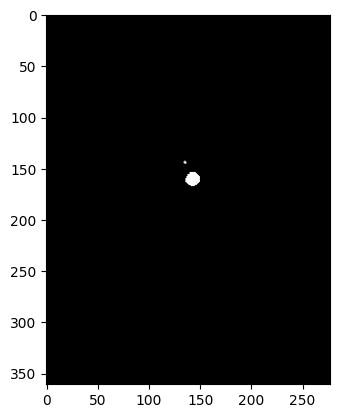

In [60]:
plt.imshow(lbl[125,:,:], cmap='gray')

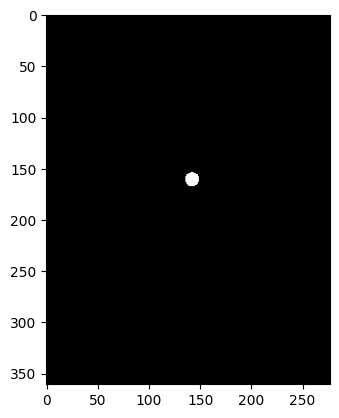

In [61]:
plt.imshow(prd[125,:,:], cmap='gray')